# Implémentation du modèle U-Net Model sur le jeu de donnée Inria 

**Objectif:** le but de ce notebook est de montrer toutes les différentes étapes pour l'implémentation du modèle UNet. Dans notre cas, nous allons utiliser le jeu de donnée Inria. Nous allons explorer toute la pipeline : 
- 1) Dataset - Dataloader
- 2) UNet Model
- 3) Training & Evaluate Model

### Root Variables 

In [66]:
import os 

In [67]:
root = '/home/ign.fr/ttea/Code_IGN/AerialImageDataset'
train_dir = os.path.join(root,'train/images')
gt_dir = os.path.join(root,'train/gt')
test_dir = os.path.join(root,'test/images')

### Import Libraries 

In [68]:
import numpy as np
import functools
import math
%matplotlib inline
import matplotlib.pyplot as plt
import random
import mock
import itertools
import pandas as pd 

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils import data
import torchnet as tnt
from tqdm.notebook import tqdm as tqdm_nb

import rasterio
from rasterio.plot import reshape_as_image
import rasterio.mask
from rasterio.features import rasterize
from rasterio.windows import Window

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, auc

In [69]:
var= pd.read_json('variables.json')

## Inria Dataset 

L'Étiquetage des images aériennes Inria aborde un thème central de la télédétection : l'étiquetage automatique au pixel près de l'imagerie aérienne
    
    
**Caractéristiques de l'ensemble de données :**

- Couverture de 810 km² (405 km² pour l'entraînement et 405 km² pour les tests)
    
- Imagerie aérienne couleur orthorectifiée avec une résolution spatiale de 0,3 m
    
- Données de vérité terrain pour deux classes sémantiques : construction et non construction (divulguées publiquement uniquement pour le sous-ensemble d'apprentissage)



In [70]:
print("Nombre d'images pour l'entraînement :",len(os.listdir(train_dir)))
print("Nombre d'images pour le test:",len(os.listdir(test_dir)))
print("Nombre d'images vérité terrain:",len(os.listdir(gt_dir)))

Nombre d'images pour l'entraînement : 180
Nombre d'images pour le test: 180
Nombre d'images vérité terrain: 180


### Tile Image

La fonction **read_image** nous permet de lire une image en utilisant la librairie rasterio et de retourner une numpy array de taille : [nombre de canal,largeur,hauteur] 

In [71]:
def read_image(root,filename):
    """
    read image with rasterio and return an array [C, W, H]
    
    no schema/georef returned yet.
    root : root directory 
    filename : image filename as string
    
    Returns: raster as an array 
    """
    img = rasterio.open(os.path.join(root,filename))
    img_array = img.read()
    img.close()
    return img_array

**Doc:** Using Rasterio Window to slice tile from an image : 

https://rasterio.readthedocs.io/en/latest/topics/windowed-rw.html

### Visualisation des tuiles et vérité terrain  

#### Tile Img

On visualise la première image du dataset.

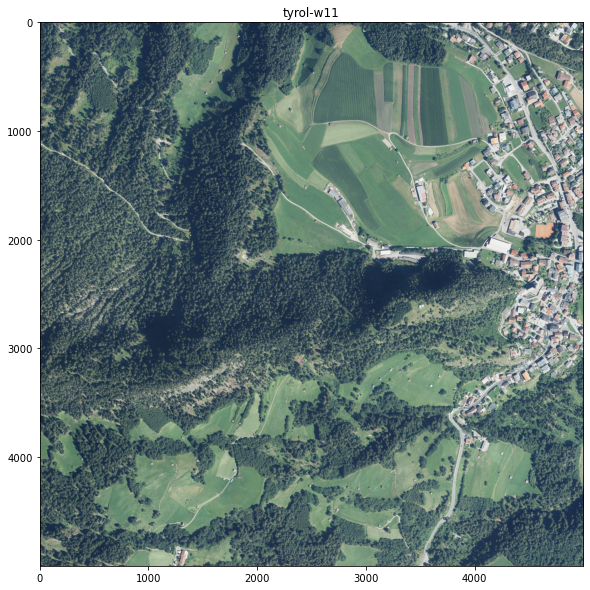

In [72]:
list_train = os.listdir(train_dir)
first_img =  list_train[0]
img = read_image(train_dir,first_img)
raster_img = reshape_as_image(img)

plt.figure(figsize=(10,10))
plt.title(first_img[:-4])
plt.imshow(raster_img)
plt.show()

#### Tile mask 

On visualise la vérité terrain correspondante à la première image. 

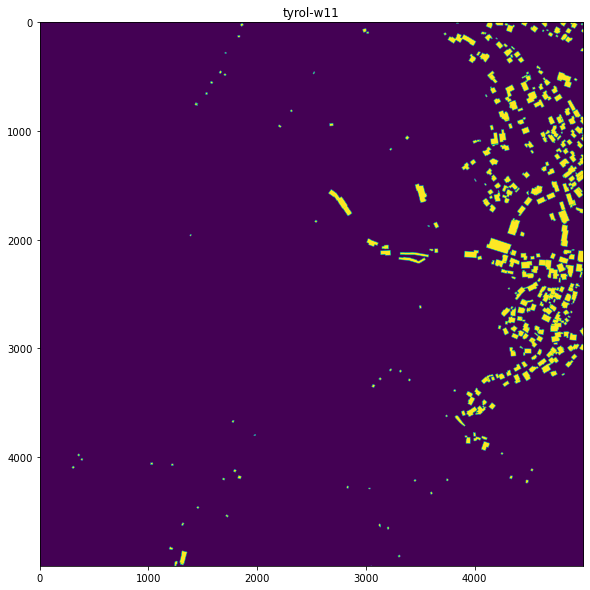

In [73]:
list_mask = os.listdir(gt_dir)
first_mask =  list_mask[0]
mask = read_image(gt_dir,first_mask)
raster_mask = reshape_as_image(mask)

plt.figure(figsize=(10,10))
plt.title(first_mask[:-4])
plt.imshow(raster_mask)
plt.show()

## 1) Dataset

Etant donné que le jeu de données d'Inria contient de lourdes images 5000x5000, on a besoin de restructurer ces images pour pouvoir travailler dessus. L'idée est de découper chaque image sous forme de tuiles et de retourner la tuile et sa vérité terrain associée. On verra dans un autre notebook comment on peut améliorer le dataset pour qu'il prenne en compte des filtres ou d'autres options. 

In [74]:
class InriaDataset(Dataset):

    def __init__(self, root, tile_size, mode,part):
        self.root = root
        self.tile_size= tile_size
        self.mode = mode
        self.part = part
        
        # Initialisation des listes d'images 
        self.train_dir = os.path.join(root,'train/images')
        self.gt_dir = os.path.join(root,'train/gt')
        self.test_dir = os.path.join(root,'test/images')

        self.train_images = os.listdir(self.train_dir)
        self.test_images = os.listdir(self.test_dir)
        self.gt_images = os.listdir(self.gt_dir)
        
        # Datalist -> contient toutes les tuiles, only_bat -> contient seulement les tuiles ayant des bâtiments  
        self.datalist = []
        self.only_bat = []
        self.used_tiles = []
        self.tiles = []
        
        score = 0
        label= 'None'
        
        
        # Nombre de tuiles par images 
        # Toutes les images dans le jeu de données Inria ont les mêmes tailles, nous allons utiliser la première 
        # image comme référence 
        with rasterio.open(os.path.join(self.train_dir, self.train_images[0])) as first_img :
            # shape dimension is [C, W, H ]
            images_width = first_img.width
            images_heigth = first_img.height
        
        
        # On détermine la largeur & hauteur de la tuile 
        tile_width = self.tile_size[0]
        tile_heigth = self.tile_size[1]
        
        # Nombre de tuiles par colonnes & lignes, ainsi que le nobmre de tuile par image 
        nb_tile_col = images_width // tile_width
        nb_tile_row = images_heigth // tile_heigth
        self.nb_tile_by_image = nb_tile_col*nb_tile_row
            
        for id_image in range(0, len(self.train_images)):
            train_image = self.train_images[id_image]
            gt_image = self.gt_images[id_image]
            for id_tile in range(0, self.nb_tile_by_image):
                self.datalist.append((id_tile, train_image, gt_image))

        self.used_tiles = self.datalist


        # Split le dataset en 80/20 (Train/Valid)
        slice_20= int(len(self.used_tiles)*(0.2))
        
        # On divise le dataset en 5 partie (4 pour l'entraînement, 1 pour la validation)
        
        # 1/5 -> validation is 1/5
        if self.part == 1 :
            if self.mode == 'train':
                del self.used_tiles[:slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[:slice_20]
       
        # 2/5
        if self.part == 2:
            if self.mode == 'train':
                del self.used_tiles[slice_20:2*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[slice_20:2*slice_20]
        
        # 3/5
        if self.part == 3:
            if self.mode == 'train':
                del self.used_tiles[2*slice_20:3*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[2*slice_20:3*slice_20]
        # 4/5
        if self.part == 4:
            if self.mode == 'train':
                del self.used_tiles[3*slice_20:4*slice_20]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[3*slice_20:4*slice_20]
        # 5/5
        if self.part == 5:
            if self.mode == 'train':
                del self.used_tiles[4*slice_20:]
                self.tiles = self.used_tiles
            elif self.mode == 'validation':
                self.tiles = self.used_tiles[4*slice_20:]
            
        # test mode 
        else: 
            self.images = self.test_images
            
    def __len__(self):
        
        return len(self.tiles)

    def __getitem__(self, idx):
        
        if self.mode =='test':
            root = self.test_dir
        else:
            root = self.train_dir
        
        tile_data = self.tiles[idx]
        id_image, id_tile = tile_data[1], tile_data[0]
                    
        image = self._get_tile(self.train_dir, id_image, id_tile)
        mask = self._get_tile(self.gt_dir, id_image, id_tile)   
        mask[np.where(mask==255)] = 1
        
        image_tensor = torch.from_numpy(image).float()
        mask_tensor = torch.from_numpy(mask)
        
        return image_tensor, mask_tensor[0,:,:]
    
    
    def _get_tile(self, root, image_file, idx):
        
        with rasterio.open(os.path.join(root, image_file)) as dataset :

            width = dataset.width
            height= dataset.height

            tile_width = self.tile_size[0]
            tile_height = self.tile_size[1]

            nb_tile_w = width // tile_width
            nb_tile_h = height // tile_height

            row, col = divmod(idx, nb_tile_w)

            tile = dataset.read(window=Window(col*tile_height,row*tile_width,tile_size[0],tile_size[1]))
            return tile  

### DataLoader

On définit le jeu de données pour l'entraînement et validation ainsi que les dataloaders.

In [75]:
train_dataset = InriaDataset(root, tile_size, 'train',1)
val_dataset =  InriaDataset(root, tile_size, 'validation',1)

train_dataloader = DataLoader(train_dataset, 8, num_workers=6,  drop_last=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, 8, num_workers=6, drop_last=True)

On va ensuite utiliser des fonctions pour visualiser les tuiles et vérité terrain du jeu de données.

In [76]:
def view(dataset, idx):
    """
    dataset: dataset contains tile & mask 
    idx : index 
    
    Returns : plot tile & mask  
    """
    
    item = dataset[idx]
    
    raster_tile = reshape_as_image(np.array(item[0]).astype(np.uint8))
    raster_gt = reshape_as_image(np.array(item[1][None,:,:]))
    
    figure, ax = plt.subplots(nrows=1, ncols=2,figsize=(10,6))
    
    ax[0].imshow(raster_tile)
    ax[0].set_title('Raster Tile')
    ax[0].set_axis_off()
    
    ax[1].imshow(raster_gt)
    ax[1].set_title('Raster Gt')
    ax[1].set_axis_off()
    
    plt.tight_layout()
    plt.show()

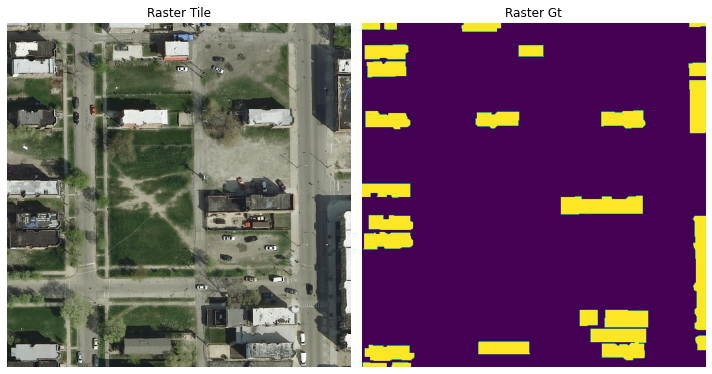

In [77]:
view(train_dataset, 5042)

La fonction view_batch nous permet de visualiser les tuiles et vérités terrains par batch. 

In [78]:
def view_batch(tiles, gt , pred = None, size = None, ncols = None):
    
    batch_size = tiles.shape[0]
    ncols = batch_size
    if size is not None :
        ncols = size
        
    if pred is None :
        figure, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(20, 8))    
    else : 
        figure, ax = plt.subplots(nrows=3, ncols=ncols, figsize=(20, 12))    
        # ax[0][idx].set_t
        
    for idx in range(ncols):
        
        item_tile = tiles[idx]
        item_gt = gt[idx]

        raster_tile = reshape_as_image(np.array(item_tile).astype(np.uint8))
        raster_gt = reshape_as_image(np.array(item_gt[None,:,:]))

        ax[0][idx].imshow(raster_tile)
        # ax[0][idx].set_title('Raster Tile '+str(idx))
        ax[0][idx].set_axis_off()

        ax[1][idx].imshow(raster_gt)
        # ax[1][idx].set_title('Raster Gt '+str(idx))
        ax[1][idx].set_axis_off()
        
        if pred is not None :
            item_pred = pred[idx]
            raster_pred = reshape_as_image(np.array(item_pred[None,:,:]))
            ax[2][idx].imshow(raster_pred)
            # ax[1][idx].set_title('Raster Gt '+str(idx))
            ax[2][idx].set_axis_off()

    plt.tight_layout()
    plt.show()

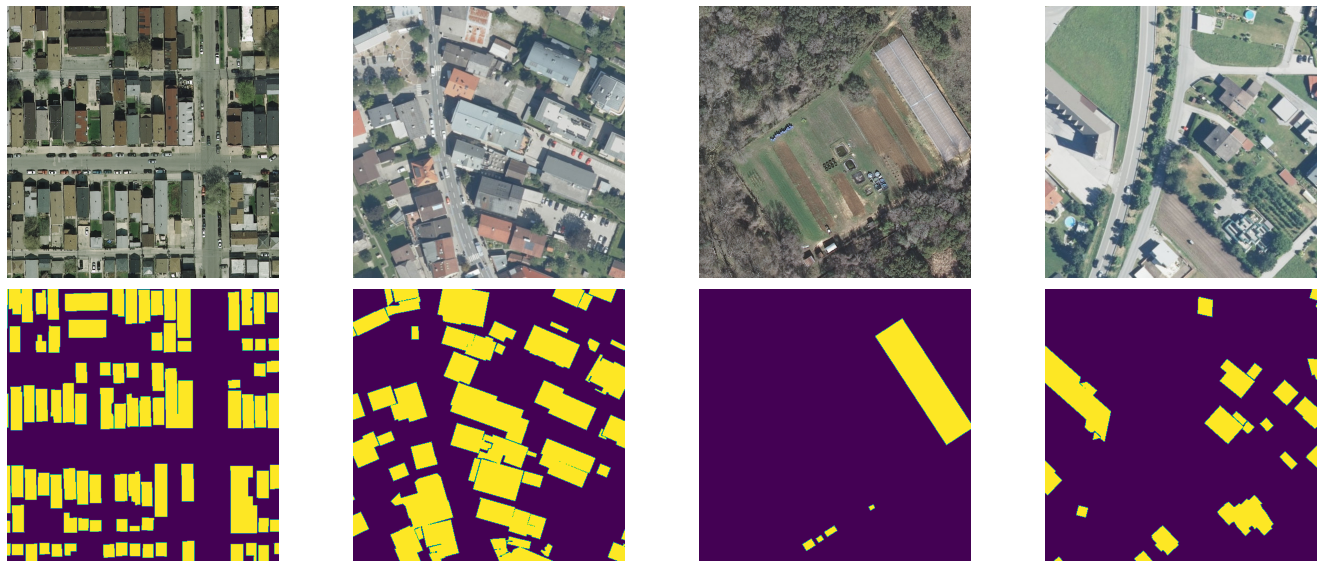

In [79]:
tiles_1, gt_1 = next(iter(train_dataloader))
view_batch(tiles_1, gt_1 , size = 4)

## 2) U-Net Model

Pour l'architecture de notre modèle de segmentation, on va se baser sur UNet. C'est un modèle de type encodeur-décodeur. 

![title](../img/Unet.png)

![title](../img/archi_unet.jpeg)

For Unet Model, the architecture will be based on this link : 
https://towardsdatascience.com/understanding-semantic-segmentation-with-unet-6be4f42d4b47

In [80]:
#Double Conv2D
def conv_block(in_channel, out_channel):
    """
    in_channel : number of input channel, int 
    out_channel : number of output channel, int
    
    Returns : Conv Block of 2x Conv2D with ReLU 
    """
    
    conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3,padding=1),
        nn.ReLU(inplace= True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3,padding=1),
        nn.ReLU(inplace= True),
    )
    return conv


# crop the image(tensor) to equal size, half left side image concatenate with right side image
def crop(target_tensor, tensor): # x,c
    """
    target_tensor : target the tensor to crop  
    tensor: tensor 
    
    Returns : tensor cropped by half left side image concatenate with right side image
    
    """
    
    target_size = target_tensor.size()[2] 
    tensor_size = tensor.size()[2]        
    delta = tensor_size - target_size     
    delta = delta // 2                    

    if (tensor_size - 2*delta)%2 == 0:
      tens = tensor[:, :, delta:tensor_size- delta , delta:tensor_size-delta]

    elif (tensor_size -2*delta)%2 ==1:
      tens = tensor[:, :, delta:tensor_size- delta -1  , delta:tensor_size-delta -1]
    return tens

class UNet(nn.Module):
  """
  UNet network for semantic segmentation
  """
  
  def __init__(self, n_channels,  n_class, cuda = 1):
    """
    initialization function
    n_channels, int, number of input channel
    conv_width, int list, depth of the convs
    n_class = int,  the number of classes
    """
    super(UNet, self).__init__() #necessary for all classes extending the module class
    self.is_cuda = cuda
    
    self.n_class = n_class
    
    #-------------------------------------------------------------
    
    ## Encoder 
    
    # Conv2D (input channel, outputchannel, kernel size)
    
    self.c1 = conv_block(3,16)
    self.p1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.c2 = conv_block(16,32)
    self.p2 = nn.MaxPool2d(kernel_size=2, stride=2)
    
    self.c3 = conv_block(32,64)
    self.p3 = nn.MaxPool2d(kernel_size=2, stride=2)  
    
    self.c4 = conv_block(64,128)
    self.p4 = nn.MaxPool2d(kernel_size=2, stride=2)      
    
    self.c5 = conv_block(128,256)

    #--------------------------------------------------------------

    ## Decoder 
    
    # Transpose & UpSampling Convblock   
    self.t6 = nn.ConvTranspose2d(256,128, kernel_size= 2, stride=2)
    self.c6 = conv_block(256,128)

    self.t7 = nn.ConvTranspose2d(128,64, kernel_size=2, stride=2)
    self.c7 = conv_block(128,64)

    self.t8 = nn.ConvTranspose2d(64,32, kernel_size=2, stride=2)
    self.c8 = conv_block(64,32)

    self.t9 = nn.ConvTranspose2d(32,16, kernel_size=2, stride=2)
    self.c9 = conv_block(32,16)
    
    # Final Classifyer layer 
    self.outputs = nn.Conv2d(16, n_class, kernel_size= 1)
    
    #weight initialization

    self.c1[0].apply(self.init_weights)
    self.c2[0].apply(self.init_weights)
    self.c3[0].apply(self.init_weights)
    self.c4[0].apply(self.init_weights)
    self.c5[0].apply(self.init_weights)
    self.c6[0].apply(self.init_weights)
    self.c7[0].apply(self.init_weights)
    self.c8[0].apply(self.init_weights)
    self.c9[0].apply(self.init_weights)
    
    if cuda: #put the model on the GPU memory
      self.cuda()
    
  def init_weights(self,layer): #gaussian init for the conv layers
    nn.init.kaiming_normal_(layer.weight, mode='fan_out', nonlinearity='relu')
    
  def forward(self, input):
    """
    the function called to run inference
    """  
    if self.is_cuda: #put data on GPU
        input = input.cuda()

    # Encoder (Left Side)
    c1=self.c1(input)
    #print('input size', input.size())
    p1=self.p1(c1)
    
    c2=self.c2(p1)
    p2=self.p2(c2)
    
    c3=self.c3(p2)
    p3=self.p3(c3)
    
    c4=self.c4(p3)
    p4=self.p4(c4)
    
    c5=self.c5(p4)

    list_encoder =[c1,p1,c2,p2,c3,p3,c4,p4,c5]

    # Decoder (Right Side)
    u6=self.t6(c5)
    y4 = crop(u6,c4)
    concat4 = torch.cat([u6,y4],1)
    x6=self.c6(concat4)
    
    u7=self.t7(x6)
    y3 = crop(u7,c3)
    x7=self.c7(torch.cat([u7,y3],1))
    
    u8=self.t8(x7)
    y2 = crop(u8,c2)
    x8=self.c8(torch.cat([u8,y2],1))
    
    u9=self.t9(x8)
    y1=crop(u9,c1)
    
    x9=self.c9(torch.cat([u9,y1],1))
    
    # Final Output Layer
    out = self.outputs(x9)
    return out

On fait la prédiction sur chaque tuile et on prédit la classe (Bâti ou non-Bâti) sur chaque pixel.

In [81]:
#==================TEST UNET===============================
# Conv_width = [16,32,64,128,256,128,64,32,16]
img, mask = train_dataset[42]
unet = UNet(4,2)
pred = unet(img[None,:,:,:]) #the None indicate a batch dimension of 4 N,C,W,H
print('pred', pred)
print('output:',pred.shape)

pred tensor([[[[ 1.0112e+00, -4.2447e-01, -8.9690e-01,  ...,  4.9851e-01,
           -6.8878e-01, -1.1871e+00],
          [ 2.3300e+00,  1.4410e+00,  1.2629e-01,  ...,  1.8385e+00,
           -2.8156e-01, -2.8138e-01],
          [ 1.5583e+00,  7.7568e-01,  1.2543e+00,  ...,  2.8662e+00,
            8.3219e-01,  8.2971e-02],
          ...,
          [ 4.7283e+00,  1.3960e+00,  3.1748e+00,  ...,  2.5792e+00,
            1.4084e+00, -1.7990e-02],
          [ 2.5683e+00, -1.0907e+00, -1.6210e+00,  ...,  5.6176e-01,
           -6.9413e-01, -2.7601e-01],
          [ 6.9796e-01,  2.5125e+00,  2.2785e+00,  ...,  1.7340e+00,
            2.6789e+00,  1.2756e+00]],

         [[-9.4282e-01,  5.1866e-02, -3.7703e-03,  ...,  1.9267e-01,
            1.7351e-02,  4.6797e-01],
          [-1.2568e+00, -2.3217e-02,  3.1989e-01,  ..., -7.1815e-03,
           -1.5063e-01,  9.7120e-01],
          [-1.8234e+00, -8.6813e-01,  3.5385e-01,  ...,  3.4513e-01,
            4.1939e-01,  7.2804e-01],
          ...,


### Metrics

In [82]:
class ConfusionMatrix:
  def __init__(self, n_class, class_names):
    self.CM = np.zeros((n_class, n_class))
    self.n_class = n_class
    self.class_names = class_names
  
  def clear(self):
    self.CM = np.zeros((self.n_class, self.n_class))
    
  def add_batch(self, gt, pred):
    self.CM +=  confusion_matrix(gt, pred, labels = list(range(self.n_class)))
    
  def overall_accuracy(self):#percentage of correct classification
    return 100*self.CM.trace() / self.CM.sum()

  def class_IoU(self, show = 1):
    ious = np.diag(self.CM)/ (self.CM.sum(0) + self.CM.sum(1) - np.diag(self.CM))
    if show:
      print('  |  '.join('{} : {:3.2f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
    #do not count classes that are not present in the dataset in the mean IoU
    return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

In [83]:
# weird trick with bincount
def confusion_matrix_torch(y_true, y_pred, n_class, cuda= False):
    N = n_class
    y = N * y_true + y_pred
    
    # Count the frequency of each value in an array of non-negative ints
    y = torch.bincount(y)
    if len(y) < N * N:
        y_comp = torch.zeros(N * N - len(y), dtype=torch.long)
        if cuda :
          y_comp = y_comp.cuda()
        y = torch.cat([y, y_comp])
    y = y.reshape(N, N)
    return y

class ConfusionMatrixTorch:
  def __init__(self, n_class, class_names, cuda = 0):
    self.CM = torch.zeros((n_class, n_class))
    self.cuda = cuda
    if cuda :
        self.CM = self.CM.cuda()
        
    self.n_class = n_class
    self.class_names = class_names
  
  def clear(self):
    self.CM = torch.zeros((self.n_class, self.n_class))
    
  def add_batch(self, gt, pred):
    self.CM += confusion_matrix_torch(gt, pred, self.n_class, self.cuda)
    
  def overall_accuracy(self):#percentage of correct classification
    return 100*self.CM.trace() / self.CM.sum()

  def class_IoU(self, show = 1):
    if self.cuda :
        cm_array = self.CM.cpu().detach().numpy()
    else :
         cm_array = self.CM.numpy()
    ious = np.diag(cm_array)/ (cm_array.sum(0) + cm_array.sum(1) - np.diag(cm_array))
    if show:
      print('  |  '.join('{} : {:3.2f}%'.format(name, 100*iou) for name, iou in zip(self.class_names,ious)))
    #do not count classes that are not present in the dataset in the mean IoU
    return 100*np.nansum(ious) / (np.logical_not(np.isnan(ious))).sum()

### Testing Confusion Matrix 

In [84]:
class_names= ['None','Batiment']
m = ConfusionMatrix(2, class_names)
m.add_batch(np.array([0,1,1,1,0,0,0,0,0,1,1]), np.array([0,1,0,1,0,0,1,0,0,1,1]))
m.add_batch(np.array([0,1,1,1,0,1,0,0,1]), np.array([0,1,0,1,0,1,0,0,1]))
print('Confusion Matrix:',m.CM)
print("OA = %3.2f%%" % (m.overall_accuracy()))
m.class_IoU()

Confusion Matrix: [[9. 1.]
 [2. 8.]]
OA = 85.00%
None : 75.00%  |  Batiment : 72.73%


73.86363636363636

In [85]:
print('Confusion Matrix:',m.CM)
print('CM TP:',m.CM[0][0])
print('CM FP:',m.CM[0][1])
print('CM FN:',m.CM[1][0])
print('CM TN:',m.CM[1][1])
m.clear()

Confusion Matrix: [[9. 1.]
 [2. 8.]]
CM TP: 9.0
CM FP: 1.0
CM FN: 2.0
CM TN: 8.0


In [86]:
class_names= ['None','Batiment']
m = ConfusionMatrixTorch(2, class_names)
m.add_batch(
    torch.tensor([0,1,1,1,0,0,0,0,0,1,1], dtype=torch.long),
    torch.tensor([0,1,0,1,0,0,1,0,0,1,1], dtype=torch.long))
m.add_batch(
    torch.tensor([0,1,1,1,0,1,0,0,1], dtype=torch.long),
    torch.tensor([0,1,0,1,0,1,0,0,1],dtype=torch.long))
print('Confusion Matrix:',m.CM)
print("OA = %3.2f%%" % (m.overall_accuracy()))
m.class_IoU()
m.clear()

Confusion Matrix: tensor([[9., 1.],
        [2., 8.]])
OA = 85.00%
None : 75.00%  |  Batiment : 72.73%


### 3) Training & Evaluate Model 

### Train loop

In [87]:
def train(model, optimizer, args,lr,n_epoch,n_epoch_test,batch_size,n_class,n_channel):
  """
  model : Unet model to train 
  optimizer: optimizer 
  args: arguments defined by Mock
  
  Returns : 
  - cm : confusion matrix  
  - loss_meter : average value meter 
  """  
    
  cm_value = {"TP":[],"FP":[],"FN":[],"TN":[],"TPR":[],"FPR":[]}  
    
  """train for one epoch"""
  model.train() #switch the model in training mode
  
  #the loader function will take care of the batching
  loader = DataLoader(args['train_dataset'], batch_size,  drop_last=True, num_workers=4, shuffle=True)

  #tqdm will provide some nice progress bars
  loader = tqdm_nb(loader, ncols=500)
  
  #will keep track of the loss
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrixTorch(2, class_names = args['class_names'], cuda =  model.is_cuda)

  for index, (tiles,gt) in enumerate(loader):

    if model.is_cuda:
        gt = gt.cuda()
        
        if args['loss_name'] == 'BinaryDiceLoss':
            pass
        elif args['loss_name'] == 'BCEDiceLoss':
            pass
        else: 
            nn_loss = args['nn_loss'].cuda()

    optimizer.zero_grad() #put gradient to zero

    # Compute the prediction : Tiles (N_Batch, N_class, Width , Height)
    pred = model(tiles) 
    
    if n_class == 2:
        # Crossentropy
        loss = args['nn_loss'](pred,gt.long())
    else:
        # BCE
        if args['loss_name'] == 'BinaryCrossentropy':
            loss = args['nn_loss'](pred, torch.unsqueeze(gt.float(),1))
            
        elif args['loss_name'] == 'BCEDiceLoss':
            loss = args['nn_loss'](pred,gt)
        # Dice
        else: 
            loss = args['nn_loss'](pred,gt.float())
     
    # Compute gradients
    loss.backward() 
    
    optimizer.step() #one SGD step

    # if model.is_cuda:
    #    gt = gt.cpu() #back to CPU
    
    loss_meter.add(loss.item())
    
    if n_class == 1:
        pred_bin = (pred>args['threshold']).to(torch.float32)
        
    with torch.no_grad():
        
        if n_class ==1: 
            cm.add_batch(gt.view(-1),pred_bin.view(-1).long())
            
        # 2 classes 
        else: 
            cm.add_batch(gt.view(-1), pred.argmax(1).view(-1))
    
  return cm,loss_meter.value()[0], cm_value

def eval(model, args,lr,n_epoch,n_epoch_test,batch_size,n_class,n_channel):
  """
  model : Unet model to evaluate
  args : arguments defined by Mock
  
  Returns : 
  - cm : Confusion Matrix 
  - loss_meter : average meter value 
  
  """  

  """eval on test/validation set"""

  cm_value = {"TP":[],"FP":[],"FN":[],"TN":[],"TPR":[],"FPR":[]} 
  
  model.eval() #switch in eval mode
  
  loader = DataLoader(args['val_dataset'], batch_size,  num_workers=4, drop_last=True)
  
  loader = tqdm_nb(loader, ncols=500)
  
  loss_meter = tnt.meter.AverageValueMeter()
  cm = ConfusionMatrixTorch(2, class_names = args['class_names'],  cuda =  model.is_cuda)

  with torch.no_grad():
    display_idx = [1,]
    # display_idx = random.sample(range(0, len(val_dataset/rgs.batch_size) ), 2)
    for index, (tiles, gt) in enumerate(loader):

      if model.is_cuda:
          gt = gt.cuda()
            
      #compute the prediction
      pred = model(tiles) 
        
      if n_class == 2 :
          loss = args['nn_loss'](pred, gt.long())
      else: 
          if args['loss_name'] == 'BinaryCrossentropy':
              loss = args['nn_loss'](pred,torch.unsqueeze(gt.float(),1))
            
          elif args['loss_name'] == 'BCEDiceLoss':
              loss = args['nn_loss'](pred,gt)
          else : 
              loss = args['nn_loss'](pred,gt.float())
        
      loss_meter.add(loss.item())
             
      if n_class == 2 : 
          pred_cm = pred.argmax(1)
          cm.add_batch(gt.view(-1), pred_cm.view(-1))
        
      else : 
          pred_bin = (pred>args['threshold']).to(torch.float32)
          cm.add_batch(gt.view(-1),pred_bin.view(-1).long())  
            
      # Afficher ici Img, Mask, Pred 
      if index in display_idx :
          view_batch(tiles, gt.cpu(), pred = pred_cm.cpu().detach(), size = 4)
      
  return  cm, loss_meter.value()[0],cm_value


def train_full(args, model,lr,n_epoch,n_epoch_test,batch_size,n_class,n_channel):
  """
  args : arguments defined by Mock
  
  returns : model train & evaluate on epochs 

  """
    
  """The full training loop"""

  metrics_train = {"accuracy":[],"mIoU":[],"loss":[]}
  metrics_test = {"accuracy":[],"mIoU":[],"loss":[]}
    
  #model = UNet(n_channel, conv_width, n_class, cuda=args['cuda'])
  print('Total number of parameters: {}'.format(sum([p.numel() for p in model.parameters()])))
  
  #define the optimizer
  optimizer = optim.Adam(model.parameters(), lr=lr)
  
  for i_epoch in range(n_epoch):
    #train one epoch
    cm_train, loss_train,cm_value = train(model, optimizer, args,lr,n_epoch,n_epoch_test,batch_size,n_class,n_channel)
    print('Epoch %3d -> Train Overall Accuracy: %3.2f%% Train mIoU : %3.2f%% Train Loss: %1.4f' % (i_epoch, cm_train.overall_accuracy(), cm_train.class_IoU(), loss_train))
    
    metrics_train['accuracy'].append(cm_train.overall_accuracy())  
    metrics_train['mIoU'].append(cm_train.class_IoU())
    metrics_train['loss'].append(loss_train)
    
    if (i_epoch == n_epoch - 1) or (n_epoch_test != 0 and i_epoch % n_epoch_test == 0 and i_epoch > 0):
      #periodic testing
      cm_test, loss_test,cm_value = eval(model, args,lr,n_epoch,n_epoch_test,batch_size,n_class,n_channel)
      print('Test Overall Accuracy: %3.2f%% Test mIoU : %3.2f%%  Test Loss: %1.4f' % (cm_test.overall_accuracy(), cm_test.class_IoU(), loss_test) )
      metrics_test['accuracy'].append(cm_test.overall_accuracy())  
      metrics_test['mIoU'].append(cm_test.class_IoU())
      metrics_test['loss'].append(loss_test)
        
  if args['save_model']:
    torch.save(model.state_dict(), args['save_model_name'])      
  
  return model,metrics_train,metrics_test

### Training Model with Full Args 

In [88]:
hparam = {
    'lr':0.0001,
    'n_epoch':5,
    'n_epoch_test':int(5),
    'n_class':2,
    'batch_size':8,
    'n_channel':3,
    'conv_width':[16,32,64,128,256,128,64,32,16],
}

In [90]:
tile_size = (512,512)

weights = [0.5, 1.0]
class_weights = torch.FloatTensor(weights).cuda()

args = {
    'nn_loss':nn.CrossEntropyLoss(weight = class_weights,reduction="mean"),
    'loss_name': 'Crossentropy',
    'threshold':0.5,
    'cuda':1,
    'class_names':['None','Batiment'],
    'save_model':False,
    'save_model_name':"unet_test2_8_1.pth",
    'train_dataset':InriaDataset(var['variables']['root'],tile_size,'train',1),
    'val_dataset':InriaDataset(var['variables']['root'],tile_size,'validation',1),
}

Total number of parameters: 1941122


  0%|                                                                                                         …

None : 82.26%  |  Batiment : 33.78%
Epoch   0 -> Train Overall Accuracy: 83.73% Train mIoU : 58.02% Train Loss: 0.4649
None : 82.26%  |  Batiment : 33.78%


  0%|                                                                                                         …

None : 88.70%  |  Batiment : 54.70%
Epoch   1 -> Train Overall Accuracy: 90.06% Train mIoU : 71.70% Train Loss: 0.2885
None : 88.70%  |  Batiment : 54.70%


  0%|                                                                                                         …

None : 90.25%  |  Batiment : 59.95%
Epoch   2 -> Train Overall Accuracy: 91.49% Train mIoU : 75.10% Train Loss: 0.2473
None : 90.25%  |  Batiment : 59.95%


  0%|                                                                                                         …

None : 91.07%  |  Batiment : 62.85%
Epoch   3 -> Train Overall Accuracy: 92.24% Train mIoU : 76.96% Train Loss: 0.2255
None : 91.07%  |  Batiment : 62.85%


  0%|                                                                                                         …

None : 91.66%  |  Batiment : 64.96%
Epoch   4 -> Train Overall Accuracy: 92.78% Train mIoU : 78.31% Train Loss: 0.2107
None : 91.66%  |  Batiment : 64.96%


  0%|                                                                                                         …

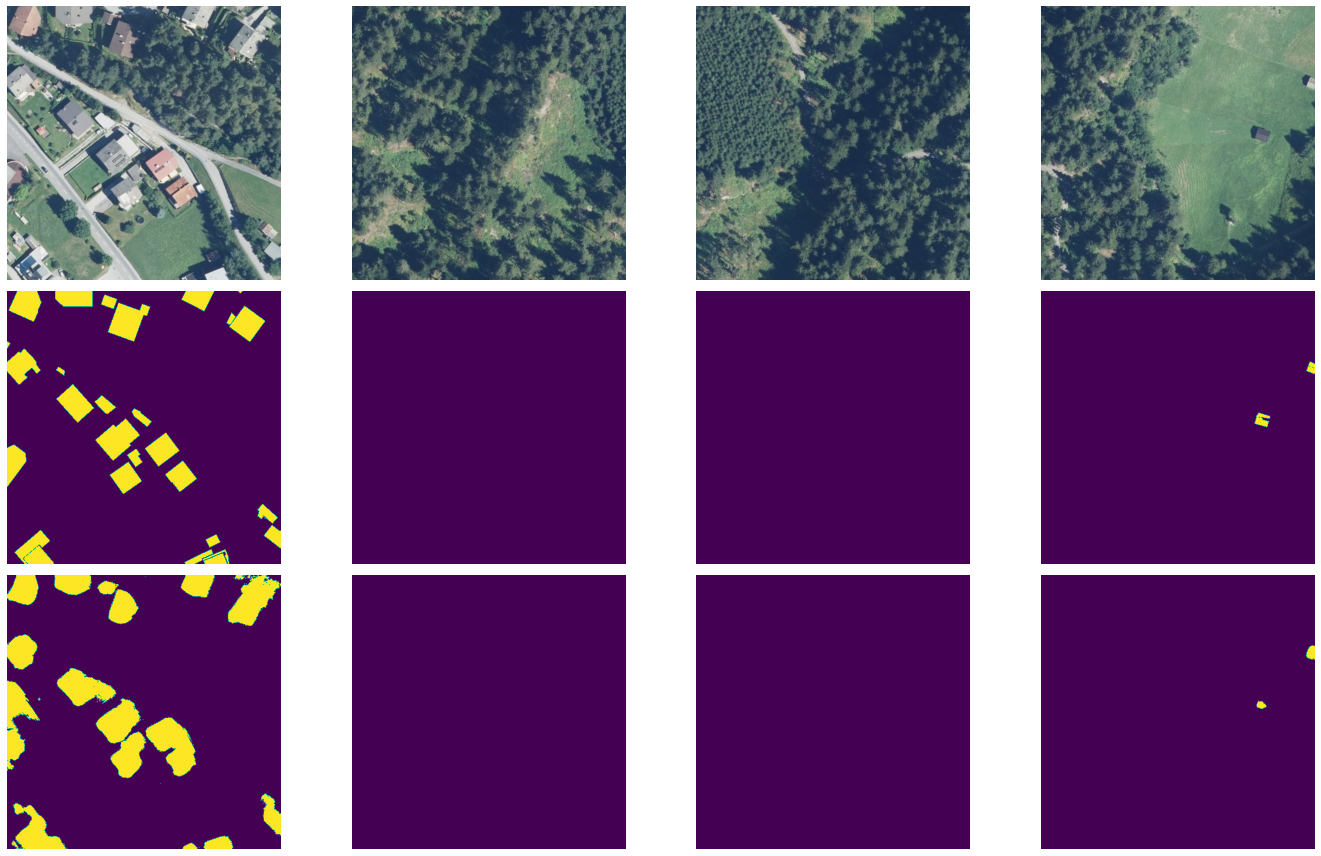

None : 91.33%  |  Batiment : 63.34%
Test Overall Accuracy: 92.46% Test mIoU : 77.34%  Test Loss: 0.1899
None : 91.33%  |  Batiment : 63.34%


In [91]:
model = UNet(hparam['n_channel'], hparam['n_class'], cuda=args['cuda'])
trained_model, metrics_train, metrics_test = train_full(args, model,hparam['lr'],hparam['n_epoch'],
                                    hparam['n_epoch_test'],hparam['batch_size'],hparam['n_class'],
                                    hparam['n_channel'])